In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BH_percentiles = [1e-2, 1e-3, 1e-4]
general_directory = "/hpcwork/zu992399/bumphunt_paper/"
plotting_direc = "plots/"

In [3]:
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['font.serif'] = []
#plt.rcParams['text.usetex'] = True
#plt.rcParams['figure.figsize'] = 3.5, 2.625
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['errorbar.capsize'] = 2
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 12
#plt.rcParams['legend.frameon'] = True

In [4]:
def calc_and_apply_threshold(samples_preds, data_preds, labels, efficiency):
    eps = np.quantile(samples_preds, 1-efficiency)
    if efficiency ==1:
        eps=0.
    N_samples_after = np.size(np.where(samples_preds>eps))
    N_samples = len(samples_preds)
    N_after = np.size(np.where(data_preds>eps))
    N = len(data_preds)
    N_bkg = np.size(np.where(data_preds[labels==0]>eps))
    N_sig = np.size(np.where(data_preds[labels==1]>eps))
    return N_samples_after, N_samples, N_after, N, N_bkg, N_sig

def significances(N_after, N, N_sig, N_bkg, eff, err, cwola):
    if cwola: 
        results = (N_after-N*eff)/np.sqrt(eff*N*2)
        rel_results = (N_after-(1+err)*N*eff)/np.sqrt(eff*N*2+(eff*err*N)**2)
        true_results = N_sig/np.sqrt(N_bkg*2)
    else: 
        results = (N_after-N*eff)/np.sqrt(eff*N)
        rel_results = (N_after-(1+err)*N*eff)/np.sqrt(eff*N+(eff*err*N)**2)
        true_results = N_sig/np.sqrt(N_bkg)
    rel_error = (N_after-N*eff)/(eff*N)
    return results, rel_results, true_results, rel_error

In [5]:
def bump_hunt_single_window(folder, cwola, window, err=None, runs=10):
	results = np.zeros((len(BH_percentiles),runs))
	true_results =  np.zeros((len(BH_percentiles),runs))
	rel_results =  np.zeros((len(BH_percentiles),runs))
	rel_error =  np.zeros((len(BH_percentiles),runs))

	arr_shape = (5,len(BH_percentiles), runs)
	N_samples_after = np.zeros(arr_shape)
	N_samples = np.zeros(arr_shape)
	N_after = np.zeros(arr_shape)
	N = np.zeros(arr_shape)
	N_bkg = np.zeros(arr_shape)
	N_sig = np.zeros(arr_shape)
	N_bkg_orig = 0

	for fold in range(5): 
		f = folder +"fold"+str(fold)+"/"
		samples_preds = np.load(f+"samples_preds.npy")
		#print(samples_preds.shape)
		data_preds = np.load(f+"test_preds.npy")
		labels = np.load(f+"Y_test.npy")
		N_bkg_orig += np.shape(data_preds[:,labels==0])[-1]
		for j, perc in enumerate(BH_percentiles):
			for i in range(len(samples_preds)):
				N_samples_after[fold, j, i], N_samples[fold, j, i], N_after[fold, j, i], N[fold, j, i], N_bkg[fold, j, i], N_sig[fold, j, i] = calc_and_apply_threshold(samples_preds[i], data_preds[i], labels, perc)
	N_samples_after = np.sum(N_samples_after, axis=0)
	N_samples = np.sum(N_samples, axis=0)
	N_after = np.sum(N_after, axis=0)
	N = np.sum(N, axis=0)
	N_bkg = np.sum(N_bkg, axis=0)
	N_sig = np.sum(N_sig, axis=0)

	if err is None:
		err = np.zeros(len(BH_percentiles))
		
	for j, perc in enumerate(BH_percentiles):
		results[j], rel_results[j], true_results[j], rel_error[j] = significances(N_after[j], N[j], N_sig[j], N_bkg[j], perc, err[j], cwola)

	return results, rel_results, true_results, rel_error

def bump_hunt(folder, cwola, err=None, runs=10):
	print(folder)

	results = np.zeros((len(BH_percentiles),9,runs))
	true_results =  np.zeros((len(BH_percentiles),9,runs))
	rel_results =  np.zeros((len(BH_percentiles),9,runs))
	rel_error =  np.zeros((len(BH_percentiles),9,runs))

	for window in range(9):
		results[:,window], rel_results[:,window], true_results[:,window], rel_error[:,window] = bump_hunt_single_window(folder+"window"+str(window+1)+"_", cwola, window, err=err, runs=runs)
	
	return results, rel_results, true_results, rel_error

In [6]:
colors_results = ["blue", "red", "orange"]
#colors_true = ["dodgerblue", "orange", "lilac"]

def plotting(rel_results, true_results, name):
    plt.figure()
    x = range(1,10)
    plt.axhline(5, color="black", linestyle="--", label="5$\sigma$")
    plt.axhline(0, color="black", label="0$\sigma$")
    for j, perc in enumerate(BH_percentiles):
        plt.errorbar(x, np.mean(rel_results[j],axis=-1), yerr = np.std(rel_results[j], axis=-1,ddof=1), label=r"$\epsilon_B$="+str(perc), fmt='o', color=colors_results[j])
        #plt.errorbar(x, np.mean(true_results[j],axis=-1), yerr = np.std(rel_results[j], axis=-1,ddof=1), fmt='o', color=colors_true[j])
        
    plt.grid()
    plt.ylabel(r"Significance")
    plt.xlabel(r"Sliding window #")
    plt.legend()
    plt.subplots_adjust(bottom=0.15, left= 0.19, top = 0.92, right = 0.965)

    plt.savefig(plotting_direc+name+".pdf")


/hpcwork/zu992399/bumphunt_paper/cwola_without/


/hpcwork/zu992399/bumphunt_paper/cwola_without/
[0.14241003 0.20813131 0.68400044]


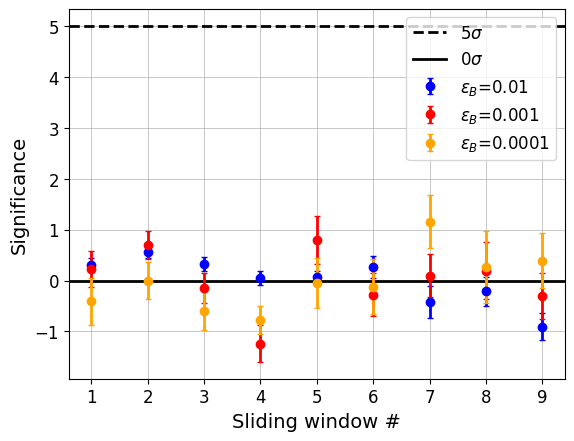

In [7]:
folder = general_directory+"cwola_without/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True)
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=np.mean(rel_error,axis=(1,2)))
plotting(rel_results, true_results, "cwola_without")
print(np.mean(rel_error,axis=(1,2)))

/hpcwork/zu992399/bumphunt_paper/cwola_without_fluctuations/


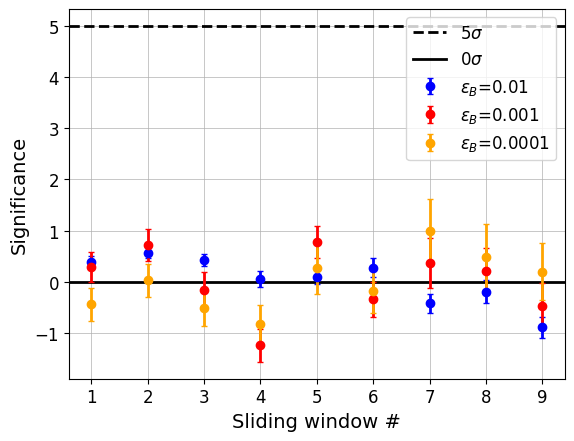

In [8]:
folder = general_directory+"cwola_without_fluctuations/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=np.mean(rel_error,axis=(1,2)), runs=100)
plotting(rel_results, true_results, "cwola_without_fluct")

In [9]:
print("Max Abweichung:",np.max(rel_results))
chi2 = np.sum(rel_results**2, axis=(1,2))
N_data = len(rel_results[1,1])*len(rel_results[1])
print("chi^2=", chi2)
print("DOF= ",N_data)

Max Abweichung: 2.783565574941657
chi^2= [199.47899678 452.8337148  450.83730299]
DOF=  900


/hpcwork/zu992399/bumphunt_paper/cwola_norm/


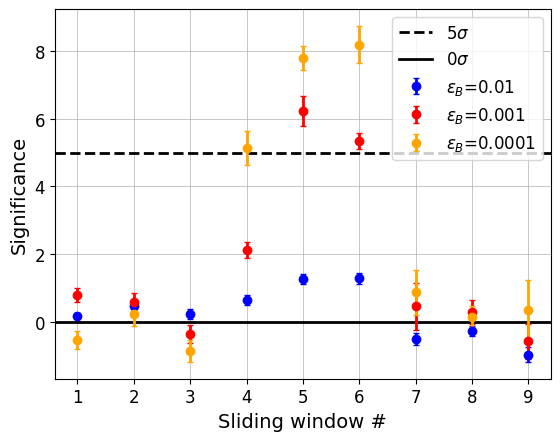

In [10]:
folder = general_directory+"cwola_norm/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=np.mean(rel_error,axis=(1,2)))
plotting(rel_results, true_results, "cwola_norm")

/hpcwork/zu992399/bumphunt_paper/cathode_without/


/hpcwork/zu992399/bumphunt_paper/cathode_without/
[0.20820882 0.40623955 0.9520765 ]


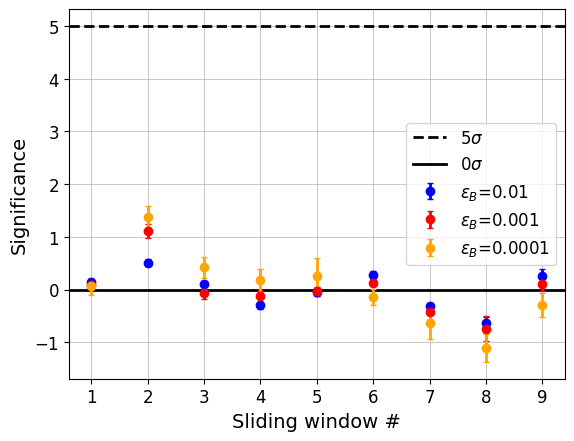

In [12]:
folder = general_directory+"cathode_without/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True)
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=np.mean(rel_error,axis=(1,2)))
plotting(rel_results, true_results, "cathode_without")
print(np.mean(rel_error,axis=(1,2)))

/hpcwork/zu992399/bumphunt_paper/cathode_without_fluctuations/


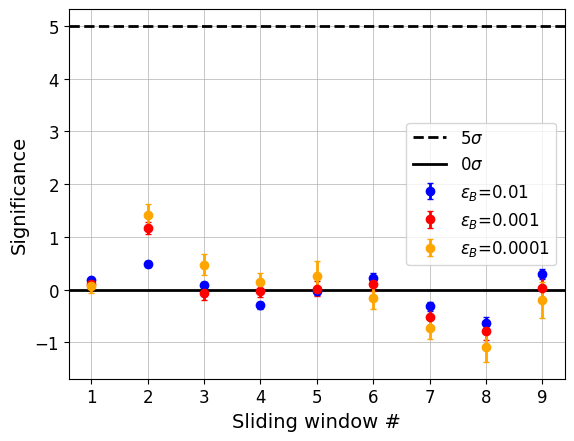

In [13]:
folder = general_directory+"cathode_without_fluctuations/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=np.mean(rel_error,axis=(1,2)), runs=100)
plotting(rel_results, true_results, "cathode_without_fluct")

In [14]:
print("Max Abweichung:",np.max(rel_results))
chi2 = np.sum(rel_results**2, axis=(1,2))
N_data = len(rel_results[1,1])*len(rel_results[1])
print("chi^2=", chi2)
print("DOF= ",N_data)

Max Abweichung: 1.914111087579969
chi^2= [105.03087791 246.1087454  457.59584623]
DOF=  900


/hpcwork/zu992399/bumphunt_paper/cathode_norm/


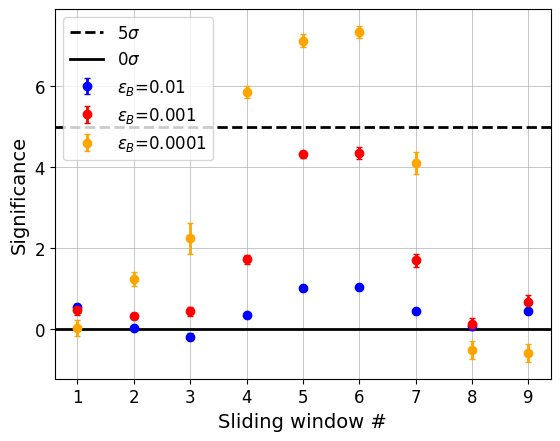

In [15]:
folder = general_directory+"cathode_norm/"
results, rel_results, true_results, rel_error = bump_hunt(folder, True, err=np.mean(rel_error,axis=(1,2)))
plotting(rel_results, true_results, "cathode_norm")

In [16]:
folder = general_directory+"IAD_without/"
results, rel_results, true_results, rel_error = bump_hunt_single_window(folder, True, 4, err=np.array([0,0,0]), runs=100)

#plotting(rel_results, true_results, "IAD_without")

In [17]:
print("Mean:", np.mean(rel_results))
print("Std:", np.std(rel_results, ddof=1))
print("Max Abweichung:",np.max(rel_results))
print("Max Abweichung:",np.min(rel_results))
chi2 = np.sum(rel_results**2, axis=1)
N_data = len(rel_results[1])
print("chi^2=", chi2)
print("DOF= ",N_data)

Mean: 0.43459793099874844
Std: 0.752274424172414
Max Abweichung: 2.4083630467809196
Max Abweichung: -1.4483305248627218
chi^2= [117.72786604  48.14713561  59.99673281]
DOF=  100
